In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from  PIL import Image
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import seaborn as sns
torch.manual_seed(0)

In [2]:
train = pd.read_csv("/content/drive/My Drive/train.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((75,75)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize((0.5,), (0.5,))
    ])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_digits(df):
    labels = []
    start_inx = 0
    if 'label' in df.columns:
        labels = [v for v in df.label.values]
        start_inx = 1
        
    digits = []
    for i in range(df.pixel0.size):
        digit = df.iloc[i].astype(float).values[start_inx:]
        digit = np.reshape(digit, (28,28))
        digit = transform(digit).type('torch.FloatTensor')
        if len(labels) > 0:
            digits.append([digit, labels[i]])
        else:
            digits.append(digit)

    return digits

In [5]:
train_X = get_digits(train)

num_workers = 0 
batch_size  = 64 
valid_size  = 0.2


num_train = len(train_X)
indices   = list(range(num_train))
np.random.shuffle(indices)
train_X = get_digits(train)

num_workers = 0 
batch_size  = 64  
valid_size  = 0.2


num_train = len(train_X)
indices   = list(range(num_train))
np.random.shuffle(indices)
split     = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_X, batch_size=batch_size,
                    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_X, batch_size=batch_size, 
                    sampler=valid_sampler, num_workers=num_workers)

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 75, 75])
torch.Size([64])


In [6]:
def train(model, train_loader, valid_loader):
  criterion = nn.CrossEntropyLoss()

  optimizer = optim.Adam(model.parameters(), lr=0.0005)
  n_epochs = 5 

  valid_loss_min = np.Inf 
  model.to(device)
  tLoss, vLoss = [], []
  for epoch in range(n_epochs):

      train_loss = 0.0
      valid_loss = 0.0
      
      model.train()
      for data, target in train_loader:
          data   = data.to(device)
          target = target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()*data.size(0)
          
      model.eval()
      for data, target in valid_loader:
          data   = data.to(device)
          target = target.to(device)
          output = model(data)
          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
      
      train_loss = train_loss/len(train_loader.dataset)
      valid_loss = valid_loss/len(valid_loader.dataset)
      tLoss.append(train_loss)
      vLoss.append(valid_loss)
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      if valid_loss <= valid_loss_min:
          torch.save(model.state_dict(), 'model_cifar.pt')
          valid_loss_min = valid_loss
  return model, tLoss, vLoss


def validate(model, valid_loader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0005)
  test_loss     = 0.0
  class_correct = [0]*10
  class_total   = [0]*10
  model.to(device)
  model.eval()

  conf_matrix = np.zeros((10,10))

  for data, target in valid_loader:
      data   = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
      for i in range(target.size(0)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
          conf_matrix[label][pred.data[i]] += 1

  test_loss = test_loss/len(valid_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(10):
      if class_total[i] > 0:
          print('Test Accuracy of %3s: %2d%% (%2d/%2d)' % (
              i, 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %3s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  plt.subplots(figsize=(10,9))
  ax = sns.heatmap(conf_matrix, annot=True, vmax=20)
  ax.set_xlabel('Predicted');
  ax.set_ylabel('True');



In [7]:
def createModelsList():
  res18 = models.resnet18()
  res18.fc = nn.Linear(in_features=512, out_features=10, bias=True)

  res50 = models.resnet50()
  res50.fc = nn.Linear(in_features=2048, out_features=10, bias=True)

  res152 = models.resnet152()
  res152.fc = nn.Linear(in_features=2048, out_features=10, bias=True)

  vgg16 = models.vgg16()
  vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=10, bias=True)

  densenet121 = models.densenet121()
  densenet121.classifier = nn.Linear(in_features=1024, out_features=10, bias=True)

  models_list = [res18, res50, res152, vgg16, densenet121]
  
  return models_list

In [8]:
models_list = createModelsList()

Epoch: 0 	Training Loss: 0.099747 	Validation Loss: 0.012886
Epoch: 1 	Training Loss: 0.041126 	Validation Loss: 0.010084
Epoch: 2 	Training Loss: 0.029913 	Validation Loss: 0.014995
Epoch: 3 	Training Loss: 0.023960 	Validation Loss: 0.011427
Epoch: 4 	Training Loss: 0.019805 	Validation Loss: 0.011624
Test Loss: 0.011624

Test Accuracy of   0: 99% (859/864)
Test Accuracy of   1: 99% (963/969)
Test Accuracy of   2: 99% (808/811)
Test Accuracy of   3: 96% (849/877)
Test Accuracy of   4: 98% (757/769)
Test Accuracy of   5: 99% (750/757)
Test Accuracy of   6: 98% (816/826)
Test Accuracy of   7: 99% (907/911)
Test Accuracy of   8: 97% (779/798)
Test Accuracy of   9: 94% (776/818)

Test Accuracy (Overall): 98% (8264/8400)
Epoch: 0 	Training Loss: 0.184558 	Validation Loss: 0.018484
Epoch: 1 	Training Loss: 0.058627 	Validation Loss: 0.019525
Epoch: 2 	Training Loss: 0.039938 	Validation Loss: 0.013468
Epoch: 3 	Training Loss: 0.033311 	Validation Loss: 0.010400
Epoch: 4 	Training Loss: 0.0

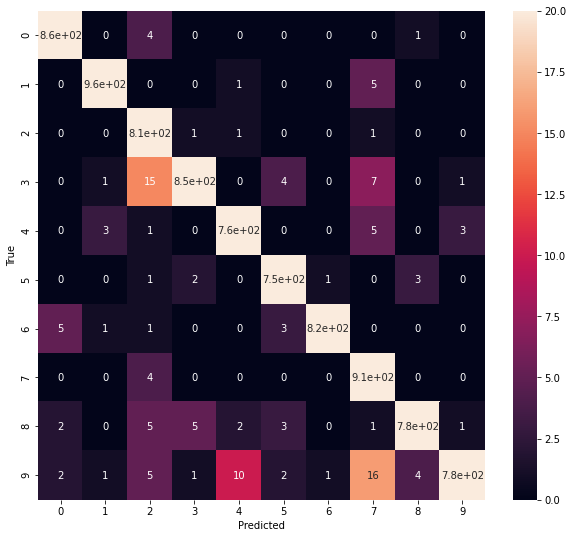

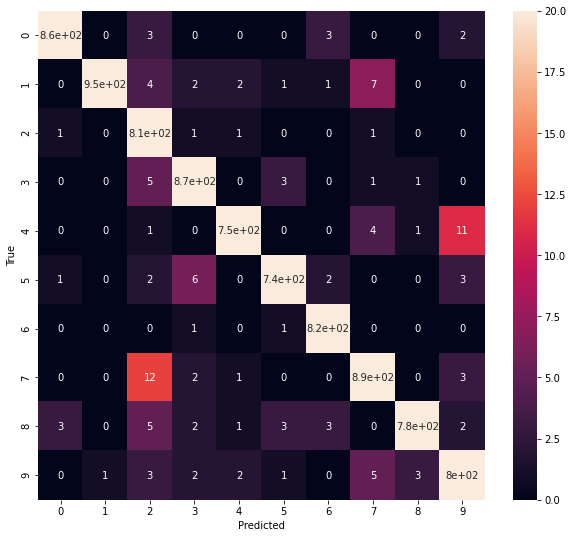

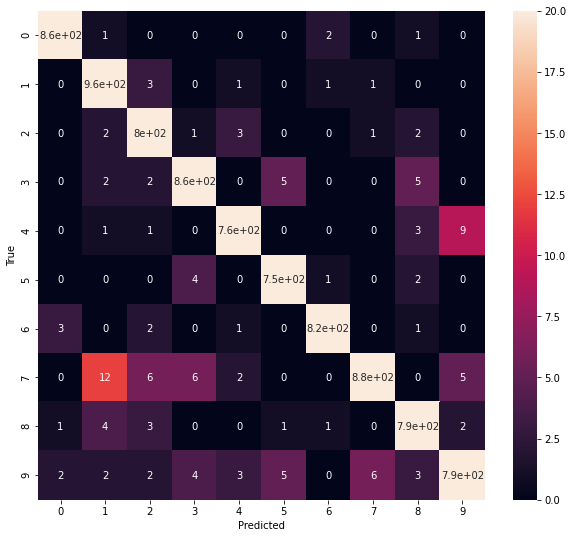

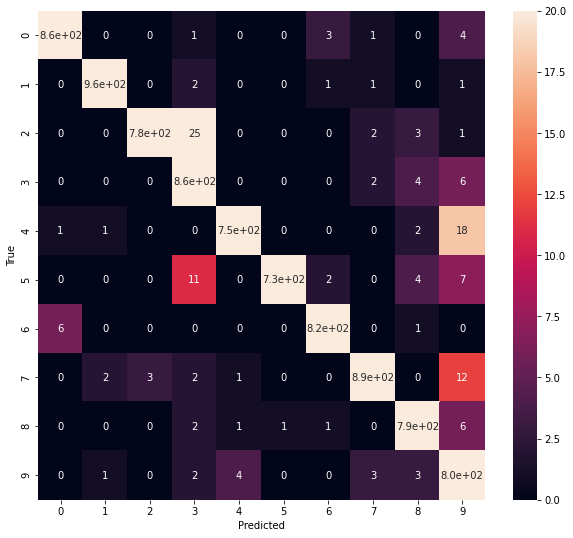

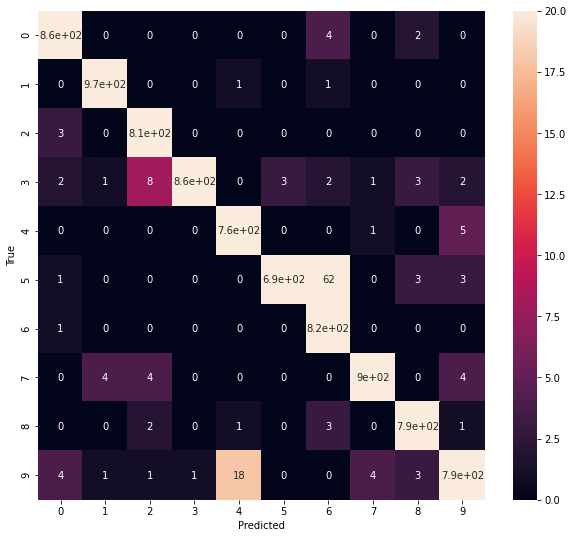

In [9]:
for i in models_list:
  model = i
  model, tLoss, vLoss = train(model, train_loader, valid_loader)
  validate(model, valid_loader)